# Logistic Regression and Regularization  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
txt = os.getcwd() + '/Data/ex2data1.txt'
df = pd.read_csv(txt, names=["midterm","final", "admission"], header=None)
print "Numer of training data: %i" %len(df)

Numer of training data: 100


In [3]:
df.head()

,midterm,final,admission
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


# 1.1 Visualizing the data

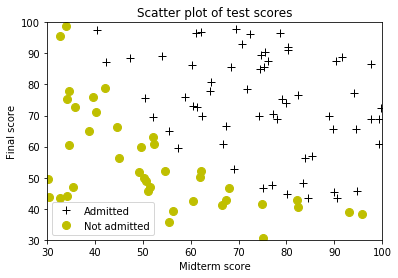

In [4]:
midterm = df[[0]]
final = df[[1]]
admission = df[[2]]

not_admitted = df.loc[df['admission']==0]
admitted = df.loc[df['admission']==1]

def plotdf(admitted, not_admitted):
    plt.plot(figsize=(12,8))
    plt.plot(admitted['midterm'],admitted['final'],'k+',label='Admitted',markersize=8)
    plt.plot(not_admitted['midterm'],not_admitted['final'],'yo',label='Not admitted',markersize=8)
    plt.legend()
    plt.ylabel("Final score")
    plt.xlabel("Midterm score")
    plt.title("Scatter plot of test scores")
    plt.xlim(30,100)
    plt.ylim(30,100)

plotdf(admitted, not_admitted)

# 1.2 Implementation

# 1.2.1 Warmup exercise: sigmoid function

In [5]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

sigmoid(0)

0.5

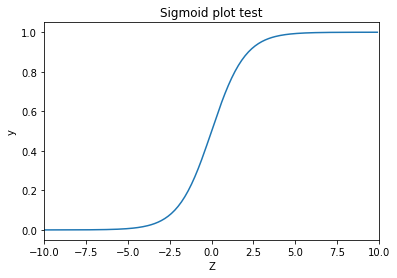

In [6]:
sig = np.arange(-10,10,.1)
plt.plot(sig,sigmoid(sig))
plt.title("Sigmoid plot test")
plt.xlim(-10,10)
plt.xlabel("Z")
plt.ylabel("y")

# 1.2.2 Cost function and gradient

In [7]:
def cost(theta, X, y):
    m = float(len(X))
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    term1 = np.multiply(-y,np.log(sigmoid(X*theta.T)))
    term2 = np.multiply((1-y),np.log(1-sigmoid(X*theta.T)))
    J = np.sum(term1-term2) / m
    return J

Restructuring data

In [8]:
df.insert(0, 'Ones',1)
cols = df.shape[1]
X = df.iloc[:,0:cols-1]
y = df.iloc[:,cols-1:cols]
theta = np.array([0,0,0])

In [9]:
print ("The cost of 0,0,0 is %s") % (cost(theta, X, y))

The cost of 0,0,0 is 0.69314718056


In [10]:
def gradient(theta, X, y):
    m = float(len(X))
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    derivative = np.zeros(theta.shape[1])
    
    error = sigmoid(X * theta.T) - y
        
    for j in range(theta.shape[1]):
        term = np.multiply(error, X[:,j])
        derivative[j] = np.sum(term)/m
    
    return derivative

Note that the function above only return one gradient step value for the optimization method later. However, I wanted to try the iteration method again before using Python's advanced optimization method.

I used over a million iterations because the learning rate had to be set down to 0.003 otherwise it diverges.

In [11]:
alpha = 0.0003
iterations = 6000000

In [12]:
def gradient_descent(theta, X, y, alpha, iterations):
    m = float(len(X))
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    temp = np.matrix(np.zeros(theta.shape))
    derivative = np.zeros(theta.shape[1])
    trail = np.zeros((iterations + 1, 3))
    c = np.zeros(iterations + 1)
    
    c[0] = cost(theta, X, y)
    
    for i in range(iterations):
        error = sigmoid(X * theta.T) - y
        
        for j in range(theta.shape[1]):
            term = np.multiply(error, X[:,j])
            derivative[j] = np.sum(term)/m
            temp[0,j] = temp[0,j] - alpha * derivative[j]
            
        theta = temp
        c[i+1] = cost(theta, X, y)
        trail[i+1,:] = theta
        
    return theta, trail, c

t, trail, c = gradient_descent(theta, X, y, alpha, iterations)
print ("Theta after 6,000,000 steps: %s") %t
print ("The cost is: %s") %c[iterations-1]

Theta after 6,000,000 steps: [[-18.53851254   0.15332058   0.14786924]]
The cost is: 0.211906833178


Plotting the gradient descent parameter decision line

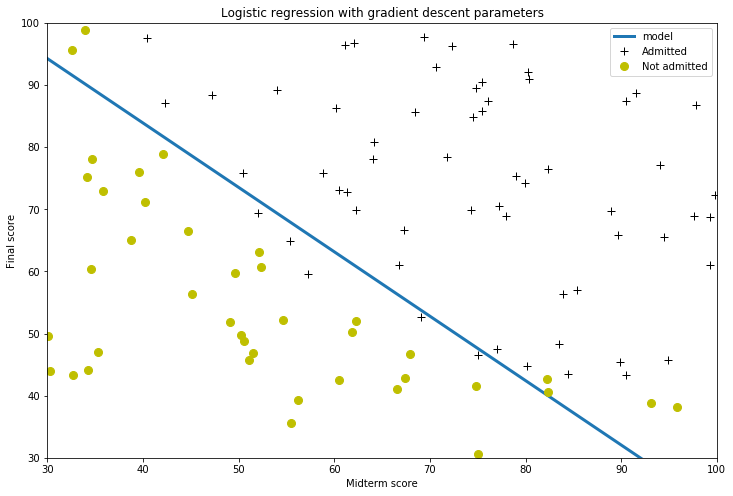

In [13]:
x = np.linspace(30,100,100)
f = (-1.0/t[0,2]) * ((t[0,1]*x) + t[0,0])

plt.subplots(figsize=(12,8))
plt.plot(x,f,label='model',linewidth=3)
plotdf(admitted, not_admitted)
plt.title('Logistic regression with gradient descent parameters')

# 1.2.3 Learning parameters using fminunc

In [14]:
import scipy.optimize as opt
opt_theta = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X,y))[0]
opt_cost = cost(opt_theta,X,y)
print ("Optimized parameters: %s") %opt_theta
print ("Optimized cost is %s") %opt_cost

Optimized parameters: [-25.16131866   0.20623159   0.20147149]
Optimized cost is 0.203497701589


Even after 6 million gradient steps, the cost is still higher than this optimized method which completed many times earlier.

Plotting the optimized decision boundary line 

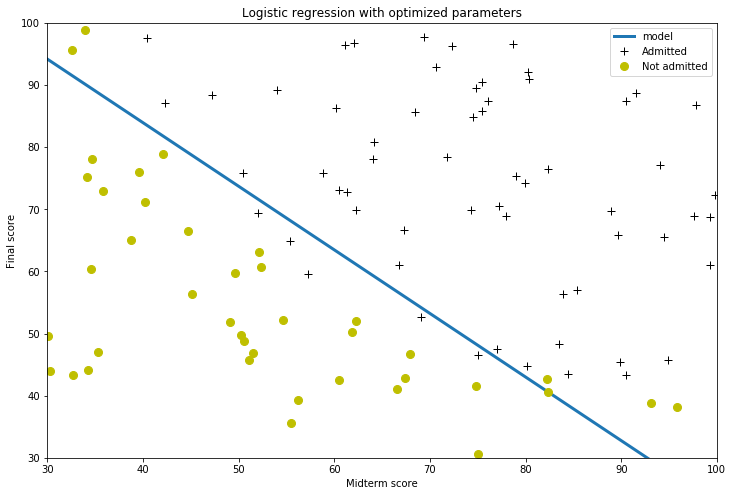

In [15]:
x = np.linspace(30,100,100)
f = (-1.0/opt_theta[2]) * ((opt_theta[1]*x) + opt_theta[0])

plt.subplots(figsize=(12,8))
plt.plot(x,f,label='model',linewidth=3)
plotdf(admitted, not_admitted)
plt.title("Logistic regression with optimized parameters")

# 1.2.4 Evaluating logsitic regression 

First, I'm showing the probability of a set of certain scores.

In [16]:
prob = float(sigmoid(np.matrix([1,45,85]) * np.matrix(opt_theta).T))
print ('For a student with scores 45 and 85, we predict an admission probability of %s') % prob
print ('Expected value: 0.775 +/- 0.002')

For a student with scores 45 and 85, we predict an admission probability of 0.776290624403
Expected value: 0.775 +/- 0.002


Now for predicting the accuracy of the model 

In [17]:
def predict(theta, X):
    m = float(len(X))
    theta = np.matrix(theta)
    X = np.matrix(X)
    p = np.zeros((len(X),1))
    j = 0
    p = [1 if i >= 0.5 else 0 for i in sigmoid(X*theta.T)]
    return p

In [18]:
def accuracy(theta, X, y):
    p = predict(theta, X)
    right = sum([1 if (est == actual) else 0 for (est,actual) in zip(np.array(p),np.reshape(np.array(y),len(X)))])
    a = float(right)/len(X) * 100
    return int(a)
print("The accuracy of this model is %r%%") %accuracy(opt_theta,X,y)

The accuracy of this model is 89%


# 2.0 Regularized logistic regression 

In [19]:
txt = os.getcwd() + '/Data/ex2data2.txt'
df2 = pd.read_csv(txt, names=["test1","test2", "outcome"], header=None)
print "Numer of training data: %i" %len(df2)

Numer of training data: 118


In [20]:
df2.head()

,test1,test2,outcome
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


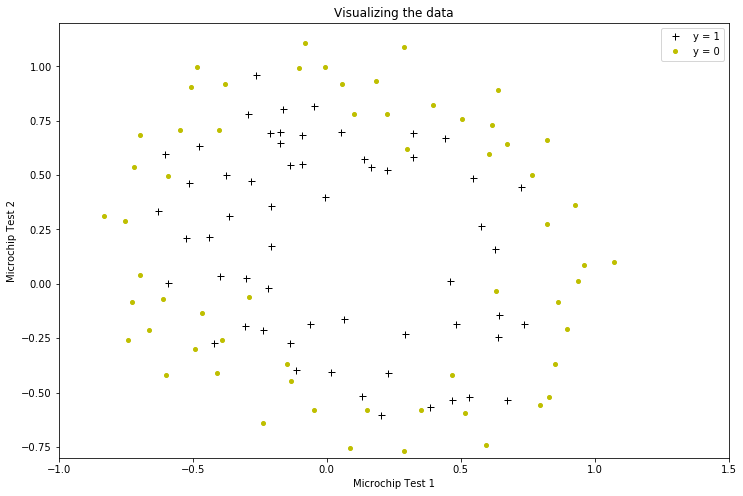

In [21]:
passed = df2.loc[df2['outcome']==1]
failed = df2.loc[df2['outcome']==0]

def plotdf2():
    plt.plot(passed['test1'],passed['test2'],'k+',label='y = 1',markersize=7)
    plt.plot(failed['test1'], failed['test2'],'yo',label='y = 0',markersize=4)
    plt.legend()
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.title('Visualizing the data')
    plt.xlim(-1,1.5)
    plt.ylim(-0.8,1.2)
    
plt.figure(figsize=(12,8))
plotdf2()

# 2.2 Feature mapping

The feature mapping function returns a matrix of 118x28, in which 28 columns are part of the feature map [1 x1 x2 x1^2 x2^2...x1x2^5 x2^6]. I created a vector of all 1's with length of X and stack the features horizontally (by column).

In [22]:
def mapFeature(X1, X2):
    degree = 6
    out = np.ones((X1.shape[0],1))
    for i in range(1, degree+1):
        for j in range(0, i+1):
            term = (np.power(X1,(i-j)) * np.power(X2,j)).reshape((len(X1),1))
            out = np.hstack((out,term))
    return out

In [23]:
X1 = df2['test1']
X2 = df2['test2']
y = df2['outcome']
X = mapFeature(X1,X2)

/Users/CptMorgan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


# 2.3 Cost function and gradient

In [24]:
def costFunctionReg(theta, X, y, lamda):
    m = float(len(X))
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y).T
    
    #Cost function
    term1 = np.multiply(-y, np.log(sigmoid(X*theta.T))) 
    term2 = np.multiply((1-y), np.log(1-sigmoid(X*theta.T)))
    reg = np.power(theta[: , 1:theta.shape[1]] , 2)
    
    J = np.sum(term1-term2)/m + (lamda/(2.0*m))*np.sum(reg) 
    
    #Gradient
    grad = np.zeros(theta.shape[1])
    
    error = sigmoid(X*theta.T) - y
    
    for j in range(theta.shape[1]):
        term = np.multiply(error, X[:,j])
        if (j == 0):
            grad[j] = np.sum(term)/m
        else:
            grad[j] = np.sum(term)/m + ((lamda/m)*theta[:,j])
    
    return J, grad

In [25]:
lamda = 1
theta = np.zeros((1,X.shape[1]))
f, grad = costFunctionReg(theta, X, y, lamda)
print ("Cost at initial theta(zeros): %r") %f
print ("Expected cost: 0.693")
print ("Gradient: %r") %grad[0:5].tolist()
print ("Expected gradients: [0.0085,   0.0188,   0.0001,   0.0503,   0.0115]")

Cost at initial theta(zeros): 0.6931471805599454
Expected cost: 0.693
Gradient: [0.00847457627118644, 0.018788093220338985, 7.77711864406773e-05, 0.05034463953635592, 0.011501330787338985]
Expected gradients: [0.0085,   0.0188,   0.0001,   0.0503,   0.0115]


In [26]:
lamda = 10
theta = np.ones((1,X.shape[1]))
f, grad = costFunctionReg(theta, X, y, lamda)
print ("Cost at test theta w/ lambda = 10: %r") %f
print ("Expected cost: 3.16")
print ("Gradient: %r") %grad[0:5].tolist()
print ("Expected gradients: [0.3460,   0.1614,   0.1948,   0.2269,   0.0922]")

Cost at test theta w/ lambda = 10: 3.1645093316150095
Expected cost: 3.16
Gradient: [0.3460450736792453, 0.16135191928091164, 0.19479575561199702, 0.22686278222504958, 0.09218567510329179]
Expected gradients: [0.3460,   0.1614,   0.1948,   0.2269,   0.0922]


# 2.3.1 Learning parameters using fminunc 

In [27]:
lamda = 0.5
theta = theta = np.zeros((1,X.shape[1]))
opt_theta = opt.fmin_tnc(func=costFunctionReg, x0=theta, args=(X,y,lamda))[0]
opt_cost,opt_grad = costFunctionReg(opt_theta,X,y,lamda)
print ("Optimized parameters: %s") %opt_theta
print ("Optimized cost is %s") %opt_cost

Optimized parameters: [  1.69996421e+00   9.73384770e-01   1.67266987e+00  -2.71223375e+00
  -1.49381523e+00  -2.11919198e+00   2.69961798e-01  -5.67583471e-01
  -5.01630933e-01  -1.94865391e-01  -1.97405979e+00  -2.04388027e-02
  -8.94053911e-01  -4.75534950e-01  -1.63004461e+00  -3.01565400e-01
  -2.95928004e-01   1.64940034e-03  -4.35519283e-01  -4.80912973e-01
  -4.74916475e-01  -1.42837948e+00   8.26705567e-02  -4.13855118e-01
   5.35053326e-02  -4.86392704e-01  -2.77078656e-01  -1.13402785e+00]
Optimized cost is 0.482934463448


## Prediction and accuracy 

In [28]:
print("The accuracy of this model is %r%%") %accuracy(opt_theta,X,y)

The accuracy of this model is 82%


## Visualizing the parameters

In [29]:
#Borrowed this plotting code from https://github.com/kaleko
def plotBoundary(theta, X, y, lamda):
    opt_theta = opt.fmin_tnc(func=costFunctionReg, x0=theta, args=(X,y,lamda))[0]
    cost, opt_grad = costFunctionReg(opt_theta,X,y,lamda)
    xval = np.linspace(-1,1.5,50)
    yval = np.linspace(-1,1.5,50)
    zval = np.zeros((len(xval),len(yval)))
    for i in xrange(len(xval)):
        for j in xrange(len(yval)):
            myfeaturesij = mapFeature(np.array([xval[i]]),np.array([yval[j]]))
            zval[i][j] = np.dot(opt_theta,myfeaturesij.T)
    zval = zval.transpose()
    u, v = np.meshgrid( xval, yval )
    mycontour = plt.contour( xval, yval, zval, [0])
    #text on boundary line 
    myfmt = { 0:'Lambda = %d'%lamda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title('Cost: '+ str(round(cost,3))+', Accuracy: '+str(accuracy(opt_theta,X,y))) 

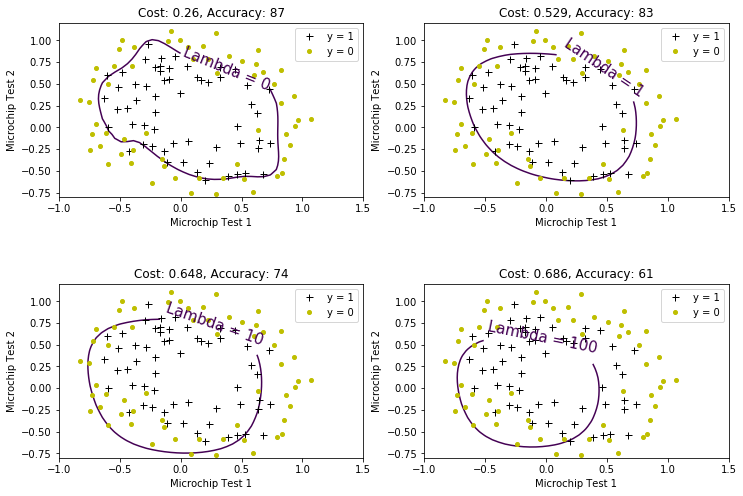

In [30]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plotdf2()
plotBoundary(theta,X,y,0)

plt.subplot(222)
plotdf2()
plotBoundary(theta,X,y,1)

plt.subplots_adjust(hspace=0.5)

plt.subplot(223)
plotdf2()
plotBoundary(theta,X,y,10)

plt.subplot(224)
plotdf2()
plotBoundary(theta,X,y,100)

As expected, the higher lambda gets, the more biased the model becomes and the lower it gets, the more variant it becomes. When lambda = 0 (no regularization), the model is overfitted and won't generalize well. When lambda = 100, the model is underfitted. I would like to see how well this model can generalize a test data set. 